In [2]:
import sys
import json
import math
import numbers
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# set up display area to show dataframe in jupyter qtconsole

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
# 使用notepad++ 修改文件格式和编码：utf-8
path_train = r'train.csv'
path_test = r'test.csv'

##文件不规则，行尾有分隔符，则可以设定index_col=False 来是的pandas不适用第一列作为行索引。
train_pdf = pd.read_csv(path_train,encoding='utf-8',engine='python',dtype='object',index_col=False)
test_pdf = pd.read_csv(path_test,encoding='utf-8',engine='python',dtype='object')

pd.set_option('max_columns',1000) 
pd.set_option('max_row',300) 
pd.set_option('display.float_format', lambda x: '%.5f' % x)


下面我们将构建TextCNN模型实现分类任务。 首先，我们先要对word2vec模型进行预处理。
TextCNN中的Embedding层需要我们把分词转化成index，因此我们把模型中的词转化成一个字典以[word : index]保存起来，方便后面的处理。

In [4]:
import time
import gensim
from gensim.models import Word2Vec

#导入word2vec模型并进行预处理
def w2v_model_preprocessing():

    #导入模型
    w2v_model = gensim.models.KeyedVectors.load_word2vec_format('word2vec_ensemble.txt',binary=False)

    word2idx = {"_PAD": 0}  # 初始化 `[word : index]` 字典
    vocab_list = [(k, w2v_model.wv[k]) for k, v in w2v_model.wv.vocab.items()]
    # 存储所有 word2vec 中所有向量的数组，其中多一位，词向量全为 0， 用于 padding 扩充
    embeddings_matrix = np.zeros((len(w2v_model.wv.vocab.items()) + 1, w2v_model.vector_size))
    #填充字典和矩阵
    for i in range(len(vocab_list)):
        word = vocab_list[i][0]
        word2idx[word] = i + 1
        embeddings_matrix[i + 1] = vocab_list[i][1]
    return w2v_model,word2idx,embeddings_matrix

time0 = time.time()
w2v_model,word2idx,embeddings_matrix = w2v_model_preprocessing()
print ('time costed {0:.2f}'.format(time.time() - time0))

D:\ProgramData\Anaconda3\envs\nlp_tf2\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':
D:\ProgramData\Anaconda3\envs\nlp_tf2\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


time costed 30.64


In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_words(data):
    words_art=[]
    for i in range(len(data)):
        words_art.append(eval(data.loc[i]))
    return words_art

#将获取的中文分词用生成的字典进行转化。获取长度同为maxlen的分词index数组，若超过则截断，不足则在后面补零

#text为文本，word_index为字典，maxlen为要保存数组的长度
def get_words_index(text, word_index,maxlen):
    texts = get_words(text)
    data = []
    for sentence in texts:
        new_txt = []
        for word in sentence:
            try:
                new_txt.append(word_index[word])  # 把句子中的分词转化为index
            except:
                new_txt.append(0)
        data.append(new_txt)

    texts = pad_sequences(data, maxlen = maxlen,padding = 'post')  # 使用kears的内置函数padding对齐句子
    return texts

In [6]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

MAX_LENGTH = 1024
#载入训练集和测试集数据
train = pd.read_csv('train2.csv')
test = pd.read_csv('test2.csv')



In [7]:
train.head(10)

,Unnamed: 0,分类,文章,字数,分词,label
0,10000,体育,欧洲杯观察：足坛格局地震 东南欧已能占半边天 搜狐体育讯 土耳其与克罗地亚在本届欧洲杯１／４...,1818,"['欧洲杯', '观察', '足坛', '格局', '地震', '东南欧', '已能', '...",8
1,10001,体育,来源：搜狐体育 作者：雷欧 主队 比分 客队 进球视频青岛 １－１ 武汉浙江 １－１ 北京搜...,2190,"['来源', '搜狐', '体育', '作者', '雷欧', '主队', '比分', '客队...",8
2,10002,体育,欧洲杯－帕夫柳琴科范尼破门 荷兰１－１俄罗斯加时 搜狐体育讯 北京时间６月２２日，２００８欧...,2078,"['欧洲杯', '帕夫', '柳琴', '科范尼', '破门', '荷兰', '俄罗斯', ...",8
3,10003,体育,郅联璧合配合日臻完善 斯杯之前尤纳斯再谈裁员 ７年后重登上海滩，中国男篮来去匆匆。队长刘炜回...,1810,"['郅', '联璧', '合', '配合', '日臻完善', '斯杯', '之前', '尤纳...",8
4,10004,体育,盘踞世界第一逼近五百周 伍兹创造高尔夫里程碑 搜狐体育讯 下周一，老虎－伍兹将第４９９周稳坐...,1893,"['盘踞', '世界', '第一', '逼近', '五百', '周伍', '兹', '创造'...",8
5,10005,体育,第五日看点：郑洁挑战ＮＯ．１ 费天王冲击男单１６强 搜狐体育讯 北京时间６月２７日晚，２００...,2082,"['第五日', '看点', '郑洁', '挑战', '费', '天王', '冲击', '男单...",8
6,10007,体育,王德显改变双姝命运 邢慧娜孙英杰成败均因一人 ２００７年年底，邢慧娜来到了北京。田管中心已经...,1855,"['王德显', '改变', '双姝', '命运', '邢慧娜', '孙', '英杰', '成...",8
7,10008,体育,半场实录：皮尔斯异军突起 湖人队领先凯尔特人 搜狐直播员：搜狐网友：赛式是２３２制的，还是主...,8550,"['半场', '实录', '皮尔斯', '异军突起', '湖人队', '领先', '凯尔特人...",8
8,10009,体育,温格：德国可成英格兰榜样 三狮军团差在意志力 晨报特派记者 甘慧（奥地利维也纳６月２９日电）...,2162,"['温格', '德国', '可成', '英格兰', '榜样', '三狮', '军团', '差...",8
9,10010,体育,欧洲杯－范尼斯内德建功 荷兰３－０狂屠意大利 搜狐体育讯 北京时间６月１０日凌晨２：４５，２...,2643,"['欧洲杯', '范', '尼斯', '德', '建功', '荷兰', '狂屠', '意大利...",8


In [8]:
#训练集数据预处理
X_train = get_words_index(train['分词'],word2idx,MAX_LENGTH) # 获取分词index
y_train = train.label #获取label
y_train = to_categorical(y_train, num_classes=12) # 将标签转化为one-hot形式保存 数据里面总共12个类别

#划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

#测试集数据预处理
X_test = get_words_index(test['分词'],word2idx,MAX_LENGTH) # 获取分词index
y_test = test.label
y_test = to_categorical(y_test, num_classes=12) # 将标签转化为one-hot形式保存
print("Dataset load finished.")

Dataset load finished.


In [15]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense,Dropout,Activation,Input, Lambda, Reshape,concatenate
from tensorflow.keras.layers import Embedding,Conv1D,MaxPooling1D,GlobalMaxPooling1D,Flatten,BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_textcnn():
    #构建textCNN模型
    # word2vec预处理
    w2v_model_preprocessing()

    main_input = Input(shape=(MAX_LENGTH,), dtype='float64')
    # 词嵌入（使用预训练的词向量）
    embedder = Embedding(
                         len(embeddings_matrix), #表示文本数据中词汇的取值可能数,从语料库之中保留多少个单词
                         300, # 嵌入单词的向量空间的大小
                         input_length=MAX_LENGTH, #规定长度 
                         weights=[embeddings_matrix],# 输入序列的长度，也就是一次输入带有的词汇个数
                         trainable=False # 设置词向量不作为参数进行更新
                         )

    embed = embedder(main_input)

    # 词窗大小分别为3,4,5
    cnn1 = Conv1D(256, 3, padding='same', strides=1, activation='relu',kernel_regularizer=l2(0.05))(embed)
    cnn1 = MaxPooling1D(pool_size=4)(cnn1)
    cnn2 = Conv1D(256, 4, padding='same', strides=1, activation='relu',kernel_regularizer=l2(0.05))(embed)
    cnn2 = MaxPooling1D(pool_size=4)(cnn2)
    cnn3 = Conv1D(256, 5, padding='same', strides=1, activation='relu',kernel_regularizer=l2(0.005))(embed)
    cnn3 = MaxPooling1D(pool_size=4)(cnn3)

    # 合并三个模型的输出向量
    cnn = concatenate([cnn1, cnn2, cnn3], axis=-1)
    flat = Flatten()(cnn)
    drop = Dropout(0.5)(flat)
    # 12 个类别
    main_output = Dense(12, activation='softmax')(drop)

    model = Model(inputs=main_input, outputs=main_output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()

    return model

In [17]:
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

def run_textcnn(model):
    # 运行textCNN模型

    # 声明回调函数
    lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1) # 学习率降低
    tensorboard = TensorBoard(log_dir='.') #保存日志
    early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
    checkpointer = keras.callbacks.ModelCheckpoint("weights_textcnn.best.hdf5", monitor='val_loss', verbose=1, save_best_only=True) #增加checkpoint

    # 模型训练
    history = model.fit(X_train, y_train,
              batch_size=64,
              epochs=10,
              verbose=1,
              validation_data=(X_val,y_val),
              shuffle=True,
              callbacks=[lr_reducer, checkpointer, tensorboard, early_stopper])

    # 模型保存
    model.save('textcnn.h5')
    print('Model Saved!')

    #保存训练集和验证集的accuracy和loss
    acc=history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    np_acc = np.array(acc).reshape((1,len(acc))) #reshape是为了能够跟别的信息组成矩阵一起存储
    np_valacc = np.array(val_acc).reshape((1,len(val_acc)))
    np_loss =np.array(loss).reshape((1,len(loss)))
    np_valloss = np.array(val_loss).reshape((1,len(val_loss)))
    np_out = np.concatenate([np_acc,np_valacc,np_loss,np_valloss],axis=0)
    np.savetxt('textcnn_history.txt',np_out)    

    print("File Saved!")

    return history

model = build_textcnn()
history = run_textcnn(model)

D:\ProgramData\Anaconda3\envs\nlp_tf2\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':
D:\ProgramData\Anaconda3\envs\nlp_tf2\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1024, 300)    50316600    input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 1024, 256)    230656      embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 1024, 256)    307456      embedding_5[0][0]                
____________________________________________________________________________________________

Classification Report
              precision    recall  f1-score   support

           0     0.8776    0.7960    0.8348      1000
           1     0.9824    0.8940    0.9361      1000
           2     0.9770    0.7630    0.8568      1000
           3     0.9130    0.9030    0.9080      1000
           4     0.8875    0.8520    0.8694      1000
           5     0.9268    0.8360    0.8791      1000
           6     0.8220    0.9050    0.8615      1000
           7     0.9720    0.9380    0.9547      1000
           8     0.9801    0.9840    0.9820      1000
           9     0.9147    0.8150    0.8620      1000
          10     0.7330    0.9250    0.8179      1000
          11     0.9523    0.7780    0.8564      1000

   micro avg     0.9043    0.8658    0.8846     12000
   macro avg     0.9115    0.8658    0.8849     12000
weighted avg     0.9115    0.8658    0.8849     12000
 samples avg     0.8658    0.8658    0.8658     12000



D:\ProgramData\Anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


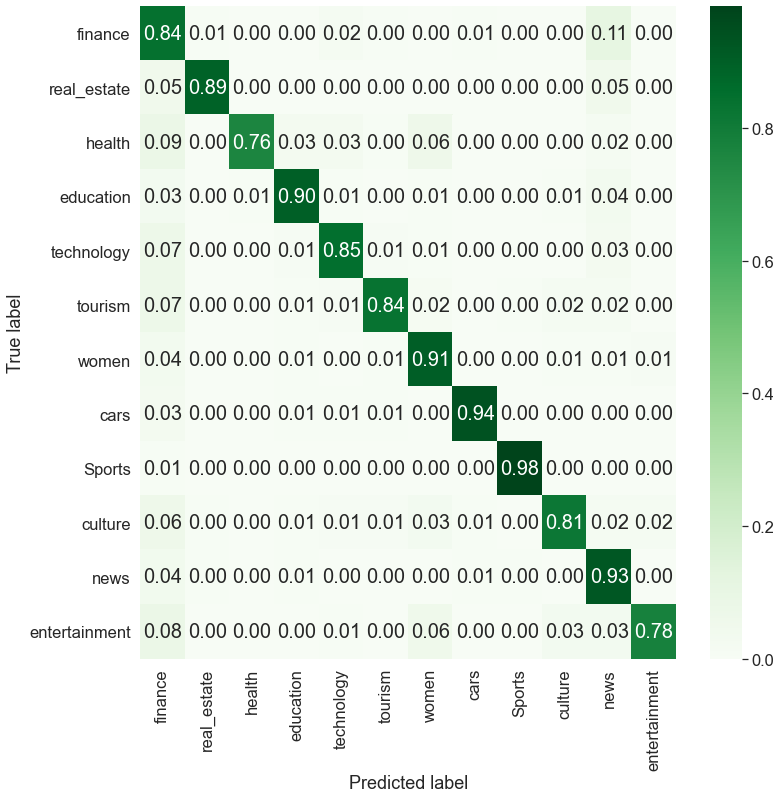

In [22]:
import h5py
import seaborn as sns
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def evaluate_textcnn(modelpath):
    #查看textCNN表现

    # 加载模型并获取预测label
    model = load_model(modelpath)
    y_pred = model.predict(X_test, batch_size=64, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
    y_pred = np.rint(y_pred)
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    #绘制confusion matrix
    category_labels = ['finance','real_estate','health', 'education', 'technology', 'tourism','women','cars','Sports','culture','news','entertainment']
    cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.set(font_scale=1.5)
    # 12 个类别
    fig, ax = plt.subplots(figsize=(12,12))
    ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=False,
                    cmap="Greens", yticklabels=category_labels, xticklabels=category_labels, vmin=0, vmax=np.max(cm_normalised),
                    fmt=".2f", annot_kws={"size": 20})
    ax.set(xlabel='Predicted label', ylabel='True label')

    #打印classification report
    print("Classification Report")
    print(classification_report(y_test, y_pred, digits=4))

evaluate_textcnn('textcnn.h5')